# Kaggle Project

Deep learning models are widely used for image classification. The goal of this project is to compare state-of-the-art models on a subset of ImageNet dataset.

The link of the project is : https://www.kaggle.com/competitions/modia-ml-2024/overview

**Notice** : You should upload a report, together with your code to Moodle, for the validation of the course. Do not copy-paste other people’s report or code.

**Due** : 27 Juin 2024.

## 1 Learn how to use Pytorch

Refer to the website https://pytorch.org/tutorials/beginner/basics/intro.html.

## 2 Train state-of-the-art CNN models

The goal is to achieve a good classification accuracy on the test dataset, using Pytorch.

 - Implement one or two models from the following list :
    - LeNet Model [1]
    - AlexNet Model [2]
    - ResNet Model [3]

 - In your report, you should give a precise definition of the model which you use, e.g. the number of layers and the type of each layer in CNN.

 - Pre-process your images in black and white

 - Pre-process your images so that they have the same input size to your model, e.g. use data augmentation.

 - Train your model using mini-batch SGD. Specify the optimization method which you use and report the total training time. To reduce the training time, you may use a GPU card.

 - Perform your parameter turning on a validation set to avoid over-fitting. Summarize your results in table/figure.

In [1]:
# Imports
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
import tqdm
from tqdm.auto import tqdm
import gpustat


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
gpu_stats = gpustat.new_query()
print(gpu_stats)

#device = torch.device('cpu')

Device: cuda
GPUStatCollection(host=n7student, [
  [0] NVIDIA RTX A500 Laptop GPU | 63°C,   0 % |     9 /  4096 MB | root(4M)
])


In [2]:
# Create a Train Dataset
class TrainDataset(Dataset):
    def __init__(self, labels_file, im_dir, transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = im_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + ".jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1] - 1
        if self.transform:
            image = self.transform(image)
        return image, label

# Create a Test Dataset
class TestDataset(Dataset):
    def __init__(self, im_dir, transform=None):
        self.img_dir = im_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(idx + 4000) + ".jpg")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [3]:
# Image transformations
IMAGE_SIZE = 256
transform = transforms.Compose([
    # Preprocess in black and white, and same size
    transforms.Grayscale(num_output_channels=1),
    transforms.CenterCrop(IMAGE_SIZE),
    
    # Data augmentation
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])

# Data paths
label_path = './train.csv'
train_dir = './train/'
test_dir = './test/'

# Dataset
train_dataset = TrainDataset(labels_file=label_path, im_dir=train_dir, transform=transform)
test_dataset = TestDataset(im_dir=test_dir, transform=transform)

In [4]:
# Création du modèle LeNet
class LeNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=4):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1   = nn.Linear(62*62*16, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
    
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2), stride=2)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=(2, 2), stride=2)
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# Création du modèle ResNet
class ResNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=4):
        super(ResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(512, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

In [6]:
# Hyperparameters
num_classes = 4
num_epochs = 1
batch_size = 32
learning_rate = 0.01
train_size = len(train_dataset)*0.8

#model = LeNet(num_classes=num_classes)
model = ResNet(num_classes=num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)

# Splitting the dataset
train_dataset, val_dataset = random_split(train_dataset, [int(train_size), len(train_dataset)-int(train_size)])

# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

/home/felix/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felix/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
# Training function
def train(model, criterion, optimizer, train_loader):
    model.to(device)
    model.train()
    
    train_losses = []
    train_acc = []
    
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for i, data in enumerate(train_loader):
            image = data[0].to(device)
            label = data[1].to(device)
            
            # Forward pass
            output = model(image)
            loss_value = criterion(output, label)
            train_losses.append(loss_value.item())
            
            # Calculate softmax and accuracy
            soft_output = torch.nn.functional.softmax(output, dim=1)
            _, predicted = torch.max(soft_output, 1)
            correct = (predicted == label).sum().item()
            accuracy = correct / label.size(0)
            train_acc.append(accuracy)

            # Update progress bar
            loss_cur = loss_value.item()
            current = i * len(image) + len(image)
            acc_cur = np.mean(train_acc)
            pbar.set_postfix(loss=f"{loss_cur:.7f}", current=f"{current}/{len(train_loader.dataset)}", accuracy=f"{acc_cur:.7f}")

            # Backward and optimize
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            pbar.update(1)

    return np.mean(train_losses), np.mean(train_acc)


# Validation function
def validate(model, criterion, val_loader):
    model.eval()
    
    val_losses = []
    val_acc = []
    
    with tqdm(total=len(val_loader), desc="Validation", unit="batch") as pbar:
        with torch.no_grad():
            for data in val_loader:
                images = data[0].to(device)
                labels = data[1].to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())
                
                # Compute accuracy
                _, argmax = torch.max(outputs, 1)
                accuracy = (labels == argmax).float().mean()
                val_acc.append(accuracy.cpu().numpy())
        
                pbar.update(1)
                
                
    print(f"Val Loss: {np.mean(val_losses):.4f}, Val Acc: {np.mean(val_acc)*100:.2f}%")
    return np.mean(val_losses), np.mean(val_acc)


# Test function
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
def test(model, test_loader):
    model.eval()
    
    preds = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Get predicted labels
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
    
    return preds

Epoch 1 of 1


Training:   0%|          | 0/100 [00:00<?, ?batch/s]

Validation:   0%|          | 0/25 [00:00<?, ?batch/s]

Val Loss: 2.1099, Val Acc: 29.50%
-----------------------------------



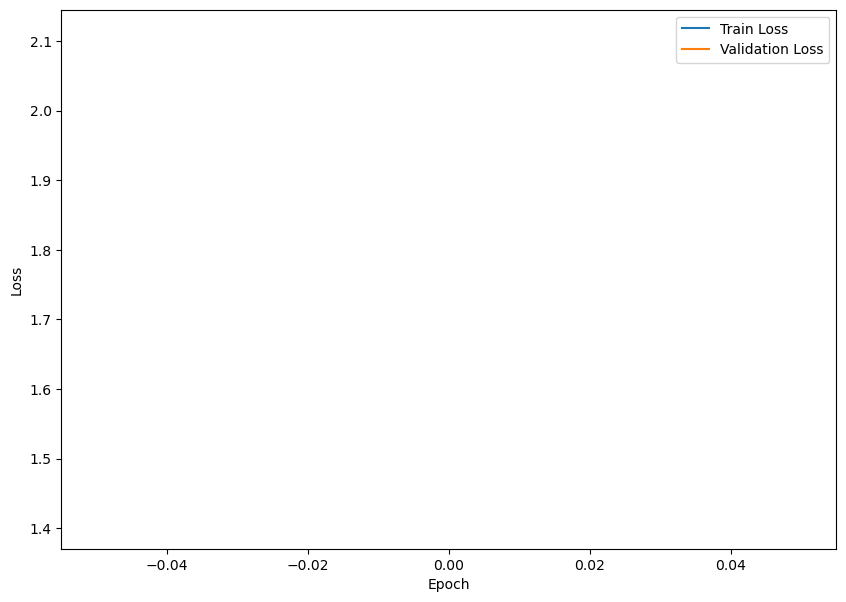

In [8]:
# Training loop
train_losses = []
val_losses = []
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = validate(model, criterion, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    scheduler.step()
    print("-----------------------------------")
    print()
   
torch.save(model.state_dict(), "model")

# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
# Predictions
predictions = test(model, test_loader)

# Save predictions
submission = pd.DataFrame({'id': np.array(range(len(predictions))) + 4000,
                           'Label': np.array(predictions) + 1})

submission.to_csv('submission.csv', index=False)

## 3 Machine learning and AI safety

### 3.1 Bias introduction in ImageNet

We try to understand how an image classification model (such as the ones trained in section 2) can be biased towards a specific outcome. To make things easier we consider the binary classification problem (2 classes).

We propose to implement the following setup :

#### 3.1.1 Biased Dataset Construction

We decide to concatenate to each of our images $x$ from ImageNet a new set of variables $\varepsilon$. As we shall specify, the second variable $\varepsilon$ is a noise-like image, which is not directly computed from $x$. Yet, it introduces some bias as we choose the value of $\varepsilon$ to be strongly correlated to the label ($0$ or $1$) of the images.

More precisely, we assume $(\tilde{x}, y) = ([x, \varepsilon], y)$ is a random sample of the modified dataset.  
We shall specify the value of $\varepsilon$ using $y$. Let $p_0 \in [0, 1], p_1 \in [0, 1]$ be two probabilities.  
Given $(\tilde{x}, y)$, the bias variable $S$ is defined as
$$
S \sim Bernoulli(p_k), \quad \text{ if } y = k, k \in \{0, 1\}.
$$

Then, we choose $\varepsilon$ according to $S$ as below :
- $\varepsilon = 0$ if $S = 0$.
- $\varepsilon \sim \mathcal{N}(0, \sigma^2I)$ if $S = 1$.

In the extreme case where $p_0 = 0$ and $p_1 = 1$, one can ignore the original image $x$ and only use $\varepsilon$ to predict $y$. In that case, our predictions are never using the image $x$ and we are only relying on the noise-like $\varepsilon$ that we introduced to the dataset.

**Advice** : in Pytorch, we can build a biased dataset by simply adding the biased variables $\varepsilon^{\{i\}}$ as a dedicated channel to the original images $x^{\{i\}}$ for each image index $i$.

**Question 1** : Build a biased dataset from ImageNet using the approach described in 3.1.1

In [10]:
# Create 2 classes
label1 = 1 # choux
label2 = 3 # choux-fleur
label_biased_path = './train_biased.csv'

# Create a csv file with the labels
df = pd.read_csv('train.csv')
df = df.loc[df['label'].isin([label1, label2])]
df['label'] = df['label'].replace(label2, 2)
df.to_csv(label_biased_path, index=False)

In [11]:
# Create a Biased Train Dataset
class BiasedTrainDataset(Dataset):
    def __init__(self, labels_file, img_dir, p0=0.5, p1=0.5, sigma=1.0, transform=None):
        self.img_labels = pd.read_csv(labels_file)
        self.img_dir = img_dir
        self.transform = transform
        self.p0 = p0
        self.p1 = p1
        self.sigma = sigma
        
        # Generate bias variable epsilon
        self.biased_labels = []
        for i in range(len(self.img_labels)):
            label = self.img_labels.iloc[i, 1]
            p = p1 if label == 1 else p0
            S = np.random.binomial(1, p)
            self.biased_labels.append(S)
        
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, str(self.img_labels.iloc[idx, 0]) + ".jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1] -1
        bias = self.biased_labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        if bias == 0:
            epsilon = torch.zeros_like(image)
        else:
            epsilon = torch.randn_like(image) * self.sigma
        
        biased_image = torch.cat((image, epsilon), dim=0)
            
        return biased_image, label, bias

#### 3.1.2 Model Bias Evaluation

We compare two different settings :

- $\textit{model}_1$ is trained on the unaltered ImageNet dataset

- $\textit{model}_2$ is trained on the biased version of ImageNet (where we append the biased variables ε to the images in a separate channel)
 
We finally compare the actual bias in both $\textit{model}_1$ and $\textit{model}_2$.

Assume $\hat{y}$ is the prediction of a model based on $\tilde{x}$. We shall separate the dataset set into $2$ groups, one with $S = 0$, the other with $S = 1$. The bias of this model can be computed from a ratio of these two groups, using the $\underline{\text{DI metric}}$ defined as :
$$
DI = \frac{P(\hat{y} = 1 | S = 0)}{P(\hat{y} = 1 | S = 1)}.
$$

In practice, a model is considered unbiased as long as the DI metric is close to $1$.

In [33]:
# Dataset
unbiased_train_dataset = BiasedTrainDataset(labels_file=label_biased_path, img_dir=train_dir, transform=transform, p0=0.5, p1=0.5)
biased_train_dataset = BiasedTrainDataset(labels_file=label_biased_path, img_dir=train_dir, transform=transform, p0=0.1, p1=0.9)

In [34]:
# Hyperparameters
num_classes = 2
num_epochs = 10
batch_size = 32
learning_rate = 0.01
train_size = len(unbiased_train_dataset)*0.8
test_size = len(unbiased_train_dataset)*0.1

#model = LeNet(num_classes=num_classes)
model1 = ResNet(num_classes=num_classes, num_channels=2)
model2 = ResNet(num_classes=num_classes, num_channels=2)

# Loss and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=5)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=5)

# Splitting the dataset
unbiased_train_dataset, unbiased_test_dataset, unbiased_val_dataset = random_split(unbiased_train_dataset, [int(train_size), int(test_size), len(unbiased_train_dataset)-(int(train_size)+int(test_size))])
biased_train_dataset, biased_test_dataset, biased_val_dataset = random_split(biased_train_dataset, [int(train_size), int(test_size), len(biased_train_dataset)-(int(train_size)+int(test_size))])

# Data loaders
unbiased_train_loader = DataLoader(dataset=unbiased_train_dataset, batch_size=batch_size, shuffle=True)
unbiased_val_loader = DataLoader(dataset=unbiased_val_dataset, batch_size=batch_size, shuffle=True)
unbiased_test_loader = DataLoader(dataset=unbiased_test_dataset, batch_size=batch_size, shuffle=False)
biased_train_loader = DataLoader(dataset=biased_train_dataset, batch_size=batch_size, shuffle=True)
biased_val_loader = DataLoader(dataset=biased_val_dataset, batch_size=batch_size, shuffle=True)
biased_test_loader = DataLoader(dataset=biased_test_dataset, batch_size=batch_size, shuffle=False)

/home/felix/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/felix/miniforge3/envs/optim/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.9194, Val Acc: 53.95%
-----------------------------------

Epoch 2 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.6920, Val Acc: 52.81%
-----------------------------------

Epoch 3 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.6904, Val Acc: 60.20%
-----------------------------------

Epoch 4 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7379, Val Acc: 53.70%
-----------------------------------

Epoch 5 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7303, Val Acc: 53.95%
-----------------------------------

Epoch 6 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7152, Val Acc: 54.78%
-----------------------------------

Epoch 7 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7406, Val Acc: 50.26%
-----------------------------------

Epoch 8 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7295, Val Acc: 57.53%
-----------------------------------

Epoch 9 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7380, Val Acc: 50.51%
-----------------------------------

Epoch 10 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.7247, Val Acc: 52.55%
-----------------------------------



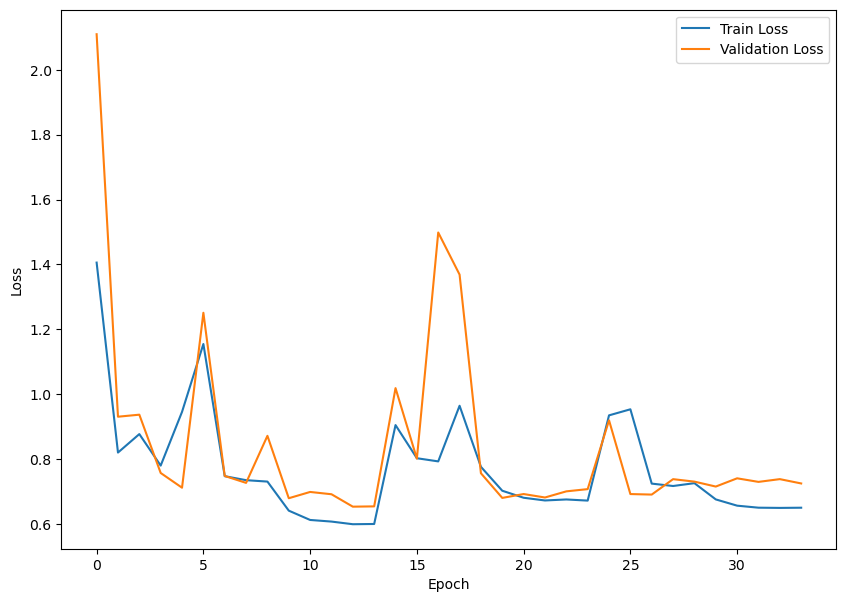

In [35]:
# Train model1 with the unbiased dataset
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_loss, train_accuracy = train(model1, criterion1, optimizer1, unbiased_train_loader)
    val_loss, val_accuracy = validate(model1, criterion1, unbiased_val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    scheduler1.step()
    print("-----------------------------------")
    print()
    
# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 1.7533, Val Acc: 41.77%
-----------------------------------

Epoch 2 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.5192, Val Acc: 86.54%
-----------------------------------

Epoch 3 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3817, Val Acc: 88.14%
-----------------------------------

Epoch 4 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3639, Val Acc: 88.14%
-----------------------------------

Epoch 5 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3472, Val Acc: 89.73%
-----------------------------------

Epoch 6 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3340, Val Acc: 89.73%
-----------------------------------

Epoch 7 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.4617, Val Acc: 84.95%
-----------------------------------

Epoch 8 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3219, Val Acc: 89.73%
-----------------------------------

Epoch 9 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3268, Val Acc: 89.73%
-----------------------------------

Epoch 10 of 10


Training:   0%|          | 0/50 [00:00<?, ?batch/s]

Validation:   0%|          | 0/7 [00:00<?, ?batch/s]

Val Loss: 0.3249, Val Acc: 89.73%
-----------------------------------



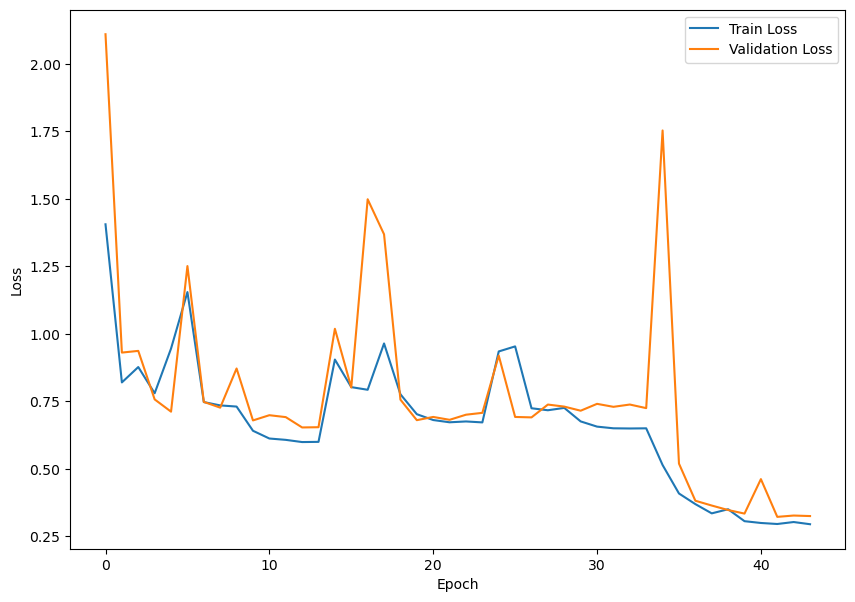

In [36]:
# Train model2 with the biased dataset
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_loss, train_accuracy = train(model2, criterion2, optimizer2, biased_train_loader)
    val_loss, val_accuracy = validate(model2, criterion2, biased_val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)
    scheduler2.step()
    print("-----------------------------------")
    print()

# Plot loss
plt.figure(figsize=(10, 7))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Question 2** : Study experimentally if $\textit{model}_2$ is biased or not on the test data. Compare you results to what you have with $\textit{model}_1$.

In [37]:
# DI metric function
def compute_DI_metric(model, test_loader):
    model.eval()
    S_0_preds = []
    S_1_preds = []
    
    with torch.no_grad():
        for images, labels, S in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            S_0_preds.extend(preds[S == 0].cpu().numpy())
            S_1_preds.extend(preds[S == 1].cpu().numpy())
    
    P_y1_S0 = np.mean(np.array(S_0_preds) == 1)
    P_y1_S1 = np.mean(np.array(S_1_preds) == 1)
    
    DI = P_y1_S0 / P_y1_S1 if P_y1_S1 != 0 else float('inf')
    return DI

In [38]:
# Compute DI metric for model1 and model2
DI_model1 = compute_DI_metric(model1, biased_test_loader)
DI_model2 = compute_DI_metric(model2, biased_test_loader)

print(f"DI metric for model1: {DI_model1}")
print(f"DI metric for model2: {DI_model2}")

DI metric for model1: 1.6702539819199314
DI metric for model2: inf


**Question 3** : Compare the accuracy scores on your test data for both $\textit{model}_1$ and $\textit{model}_2$ for the binary classification task.

In [39]:
# Test function
def test_biased(model, test_loader):
    model.eval()
    
    pred_losses = []
    pred_acc = []
    
    with torch.no_grad():
        for data in test_loader:
            images = data[0].to(device)
            labels = data[1].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            pred_losses.append(loss.item())
            
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()
            pred_acc.append(accuracy.cpu().numpy())
            
    print(f"Test Loss: {np.mean(pred_losses):.4f}, Test Acc: {np.mean(pred_acc)*100:.2f}%")
    return np.mean(pred_losses), np.mean(pred_acc)

In [40]:
# Test model1 and model2
print("Model1 (unbiased)")
test_biased(model1, unbiased_test_loader)
print("Model2 (biased)")
test_biased(model2, biased_test_loader)

Model1 (unbiased)
Test Loss: 0.6360, Test Acc: 63.54%
Model2 (biased)
Test Loss: 0.2810, Test Acc: 91.96%


(0.2810050217168672, 0.91964287)

**Question 4** : What can you conclude from the two previous questions ?

The model 2 is biased according to the DI metric. It shows when comparing the accuracy scores of the two models that the biased model has a higher accuracy score than the unbiased model. This is due to the fact that the biased model is using the noise-like $\varepsilon$ to predict the label $y$.